# 任务二 —— 共享单车使用量预测
## 任务一 —— 使用线性预测
+ 加载相关库

In [9]:
%matplotlib inline
import os
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
import kagglehub
import pandas as pd
import matplotlib.pyplot as plt

+ 从kaggle上下载数据集，并得到温度(temp)和日租量(cnt)的相关数据，并将它们转化为形状为(数据量，1)的张量。

In [73]:
# 从kaggle中下载数据集
dataset_path = kagglehub.dataset_download("lakshmi25npathi/bike-sharing-dataset")

# 加载数据集
orignal_data_day = pd.read_csv(os.path.join(dataset_path,'day.csv'))

#得到输入temp和输出cnt
#这里的inputs，outputs对应X_df, Y_df
inputs, outputs = orignal_data_day['temp'], orignal_data_day['cnt']

#转化为张量
#这里的X,Y对应X_tensor, Y_tensor
X, Y = torch.tensor(inputs.values,dtype=torch.float32), torch.tensor(outputs.values,dtype=torch.float32)
X, Y = X.reshape(-1,1), Y.reshape(-1,1)

+ 使用现有api定义简单的线性模型，初始化方法。

In [11]:
#定义线性回归神经网络
class LinearRegressionModel(nn.Module):
    def __init__(self, in_features:int, out_features:int,bias = True):
        super().__init__()
        self.linear = nn.Linear(in_features, out_features, bias = bias)

    def forward(self,x):
        return self.linear(x)

#定义初始化方法
def init_params(m):
    if type(m) == nn.Module:
        nn.init.xavier_uniform_(m.weight)
        if m.bias is not None:
            m.bias.fill_(0.)


#定义损失函数
criterion = nn.MSELoss(reduction='mean')

+ 初始化模型，设置超参数，加载数据集并开始训练。在训练后，对训练数据进行预测产生最终的拟合直线

In [13]:
#创建网络并初始化
net = LinearRegressionModel(1,1)
net.apply(init_params)
#加载数据集并设置超参数
lr = 0.5
epoch_nums = 100
batch_size = 32
dataset = TensorDataset(X,Y)
train_data = DataLoader(dataset,batch_size=batch_size ,shuffle=True)
#选择随机梯度下降作为优化器
optimizer = torch.optim.SGD(net.parameters(), lr=lr)
loss_data = []# 由于存储损失值
# 开始训练
for epoch in range(epoch_nums + 1):
    epoch_losses = []  # 存储当前epoch的所有batch损失
    for x, y in train_data:
        optimizer.zero_grad()
        y_hat = net(x)
        loss = criterion(y_hat, y)  # 注意参数顺序：预测值在前，真实值在后
        # loss是一个零维张量
        loss.backward()
        optimizer.step()
        epoch_losses.append(loss.item())  # 存储标量值
    
    # 计算当前epoch的平均损失
    avg_loss = np.mean(epoch_losses)
    loss_data.append(avg_loss)  # 存储每个epoch的平均损失
    
    if epoch % 10 == 0 and epoch != 0:
        print(f'Epoch:{epoch} Loss: {avg_loss:.4f}')

# 用训练好的模型进行预测得到最终的拟合直线
with torch.no_grad():
    y_pred = net(X)

# 打印训练后得到的参数
print("训练后的参数:")
print(net.state_dict())

Epoch:10 Loss: 2305219.6793
Epoch:20 Loss: 2481380.8315
Epoch:30 Loss: 2372239.0978
Epoch:40 Loss: 2425275.9022
Epoch:50 Loss: 2392378.1957
Epoch:60 Loss: 2410966.4076
Epoch:70 Loss: 2380222.4402
Epoch:80 Loss: 2496424.3696
Epoch:90 Loss: 2332591.5054
Epoch:100 Loss: 2454749.1359
训练后的参数:
OrderedDict([('linear.weight', tensor([[6505.7104]])), ('linear.bias', tensor([1088.2054]))])


+ 画出相关图像

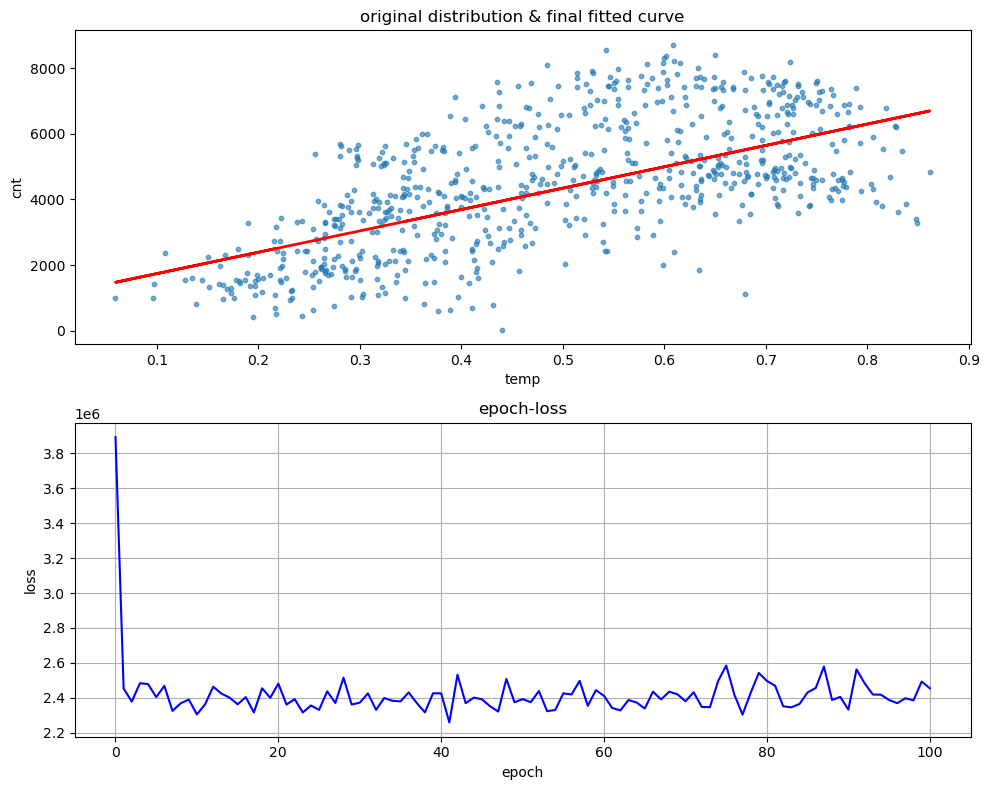

In [14]:
# 创建图表
fig, axs = plt.subplots(2, 1, figsize=(10, 8))

# 显示初始数据的散点图和拟合曲线
axs[0].scatter(X.numpy(), Y.numpy(), s=10, alpha=0.6)# 设置alpha使点变为半透明的
axs[0].set_xlabel('temp')
axs[0].set_ylabel('cnt')
axs[0].set_title('original distribution & final fitted curve')

# 绘制拟合曲线
axs[0].plot(X.numpy(), y_pred.detach().numpy(), color='r', linewidth=2)

# 绘制epoch-loss图
axs[1].plot(range(len(loss_data)), loss_data, color='b')
axs[1].set_xlabel('epoch')
axs[1].set_ylabel('loss')
axs[1].set_title('epoch-loss')
axs[1].grid(True) #使用网格

plt.tight_layout()
plt.show()

***
## 任务二 —— 拟合非线性关系
+ 定义一个含隐藏层和非线性激活函数的简单神经网络。其中，隐藏层输出等于10，非线性激活函数采用sigmoid()

In [72]:
class NonLinearModel(nn.Module):
    def __init__(self, in_features, out_features, hidden_features = 10, bias = True):
        super().__init__()
        self.linear1 = nn.Linear(in_features, hidden_features, bias=bias)
        self.sigmoid = nn.Sigmoid()
        self.linear2 = nn.Linear(hidden_features, out_features, bias=bias)

    def forward(self,x):
        x = self.linear1(x)
        x = self.sigmoid(x)
        x = self.linear2(x)
        return x

+ 替换之前采用的网络并进行训练。

In [75]:
#创建网络并初始化
net = NonLinearModel(1,1,hidden_features=10)
net.apply(init_params)

#加载数据集并设置超参数
lr = 0.1
epoch_nums = 1000
loss_data = []# 由于存储损失值
dataset = TensorDataset(X,Y)
train_data = DataLoader(dataset,batch_size=batch_size ,shuffle=True)
#选择随机梯度下降作为优化器
optimizer = torch.optim.SGD(net.parameters(), lr=lr)
# 开始训练
for epoch in range(epoch_nums + 1):
    epoch_losses = []  # 存储当前epoch的所有batch损失
    for x, y in train_data:
        optimizer.zero_grad()
        y_hat = net(x)
        loss = criterion(y_hat, y)  # 注意参数顺序：预测值在前，真实值在后
        # loss是一个零维张量
        loss.backward()
        optimizer.step()
        epoch_losses.append(loss.item())  # 存储标量值
    
    # 计算当前epoch的平均损失
    avg_loss = np.mean(epoch_losses)
    loss_data.append(avg_loss)  # 存储每个epoch的平均损失
    
    if epoch % 100 == 0 and epoch != 0:
        print(f'Epoch:{epoch} Loss: {avg_loss:.4f}')

# 打印训练后得到的参数
print("训练后的参数:")
print(net.state_dict())

Epoch:100 Loss: 4004477.5000
Epoch:200 Loss: 3932152.9891
Epoch:300 Loss: 4082024.1087
Epoch:400 Loss: 3733657.5870
Epoch:500 Loss: 3816153.2717
Epoch:600 Loss: 4061987.2826
Epoch:700 Loss: 3902781.0870
Epoch:800 Loss: 3796713.4348
Epoch:900 Loss: 3882530.2446
Epoch:1000 Loss: 3888062.2717
训练后的参数:
OrderedDict([('linear1.weight', tensor([[-1.5653e+01],
        [-1.6480e+01],
        [ 5.7062e+01],
        [ 3.0828e+01],
        [ 3.2940e+01],
        [ 5.7219e+02],
        [-2.8935e+01],
        [-9.6182e+00],
        [-2.6813e+01],
        [ 1.4947e+04]])), ('linear1.bias', tensor([-2.9857e+01, -3.2694e+01,  4.1227e+01,  6.3016e+01,  6.3034e+01,
         1.0971e+03, -5.9323e+01, -1.9953e+01, -5.2051e+01,  2.7192e+04])), ('linear2.weight', tensor([[330.3230, 537.6216, 385.7714, 721.0059, 691.8367, 612.1486, 575.4747,
         542.9622, 521.4802, 331.3747]])), ('linear2.bias', tensor([1137.3705]))])


+ 将X按温度升序排列后得到拟合曲线

In [76]:
X_sorted, indices = torch.sort(X, dim=0)
with torch.no_grad():
    y_pred = net(X_sorted)

+ 绘图（这是最初训练的结果，**下面有改进**）

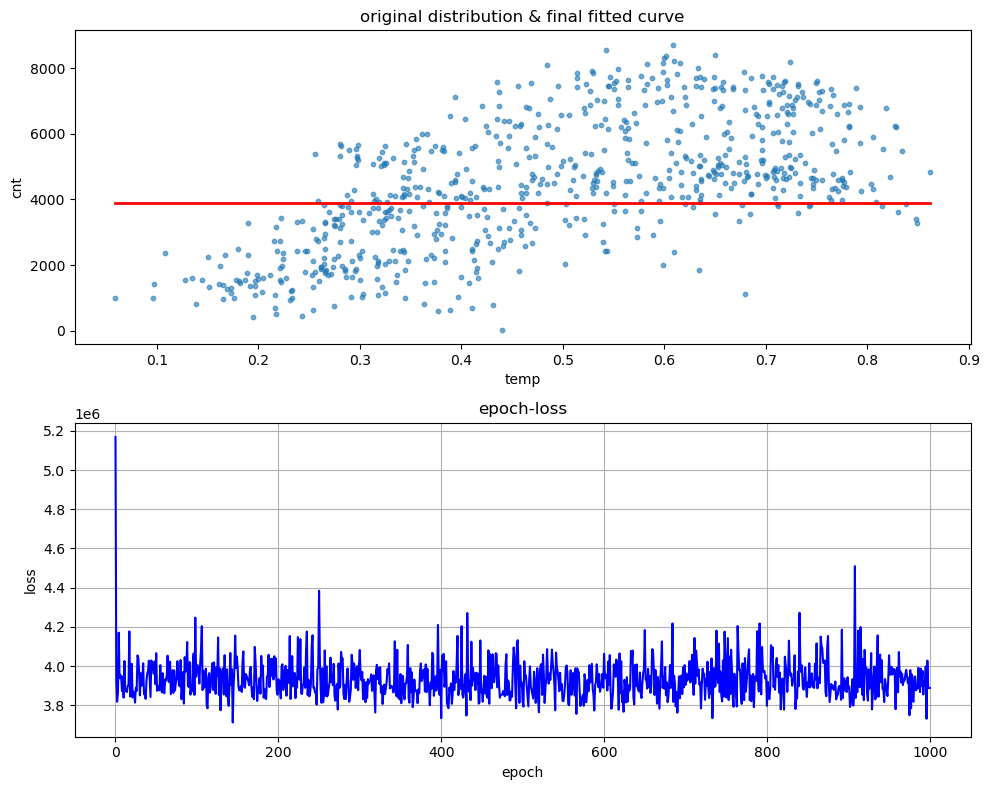

In [77]:
# 创建图表
fig, axs = plt.subplots(2, 1, figsize=(10, 8))

# 显示初始数据的散点图和拟合曲线
axs[0].scatter(X.numpy(), Y.numpy(), s=10, alpha=0.6)# 设置alpha使点变为半透明的
axs[0].set_xlabel('temp')
axs[0].set_ylabel('cnt')
axs[0].set_title('original distribution & final fitted curve')

# 绘制拟合曲线
axs[0].plot(X_sorted.numpy(), y_pred.detach().numpy(), color='r', linewidth=2)

# 绘制epoch-loss图
axs[1].plot(range(len(loss_data)), loss_data, color='b')
axs[1].set_xlabel('epoch')
axs[1].set_ylabel('loss')
axs[1].set_title('epoch-loss')
axs[1].grid(True) #使用网格

plt.tight_layout()
plt.show()

+ **训练结果分析**：可以看到，虽然模型的表达能力增强了，训练轮数增加了，但训练效果却远远没有线性模型好。一开始我很纳闷，当我看了一下训练数据后，我想明白了。只能说出题人员也是用心良苦，``temp``的值那么小却要生成``cnt``那么大的值肯定会需要很大的参数值，但当参数值过大时，学习率的设计又会变得很困难了。为此，我们需对数据进行标准化并采用对超参数不那么敏感的Adam优化器。

In [52]:
# 数据标准化
X_mean, X_std = X.mean(), X.std()
X_normalized = (X - X_mean) / X_std

Y_mean, Y_std = Y.mean(), Y.std()
Y_normalized = (Y - Y_mean) / Y_std

#重载数据集并设置超参数
dataset = TensorDataset(X_normalized,Y_normalized)
train_data = DataLoader(dataset,batch_size=batch_size ,shuffle=True)

In [69]:
#创建网络并初始化
net = NonLinearModel(1,1,hidden_features=10)
net.apply(init_params)

#加载数据集并设置超参数
lr = 0.001
epoch_nums = 1000
loss_data = []# 由于存储损失值
optimizer = torch.optim.Adam(net.parameters(), lr=lr)
# 开始训练
for epoch in range(epoch_nums + 1):
    epoch_losses = []  # 存储当前epoch的所有batch损失
    for x, y in train_data:
        optimizer.zero_grad()
        y_hat = net(x)
        loss = criterion(y_hat, y)  # 注意参数顺序：预测值在前，真实值在后
        # loss是一个零维张量
        loss.backward()
        optimizer.step()
        epoch_losses.append(loss.item())  # 存储标量值
    
    # 计算当前epoch的平均损失
    avg_loss = np.mean(epoch_losses)
    loss_data.append(avg_loss)  # 存储每个epoch的平均损失
    
    if epoch % 100 == 0 and epoch != 0:
        print(f'Epoch:{epoch} Loss: {avg_loss:.4f}')

# 打印训练后得到的参数
print("训练后的参数:")
print(net.state_dict())

Epoch:100 Loss: 0.5741
Epoch:200 Loss: 0.5509
Epoch:300 Loss: 0.5445
Epoch:400 Loss: 0.5437
Epoch:500 Loss: 0.5439
Epoch:600 Loss: 0.5447
Epoch:700 Loss: 0.5426
Epoch:800 Loss: 0.5414
Epoch:900 Loss: 0.5424
Epoch:1000 Loss: 0.5397
训练后的参数:
OrderedDict([('linear1.weight', tensor([[ 0.2341],
        [ 1.7864],
        [ 0.2342],
        [-1.6790],
        [ 1.7286],
        [ 0.3372],
        [ 0.1996],
        [ 1.3027],
        [ 1.6227],
        [ 1.7392]])), ('linear1.bias', tensor([ 0.0057,  1.1664,  0.8018, -1.3516,  1.0356,  0.3338,  0.0982, -1.5833,
         1.7033,  1.1256])), ('linear2.weight', tensor([[-0.0714,  0.5972, -0.1563, -1.3850,  0.3109, -0.1270, -0.3348, -0.7066,
          0.5114,  0.2905]])), ('linear2.bias', tensor([-0.2124]))])


+ 输出时反标准化输出

In [70]:
X_normalized_sorted, indices = torch.sort(X_normalized, dim=0)
# 预测时也要标准化输入，然后反标准化输出
with torch.no_grad():
    net.eval()
    y_pred_normalized = net(X_normalized_sorted)
    y_pred = y_pred_normalized * Y_std + Y_mean  # 反标准化

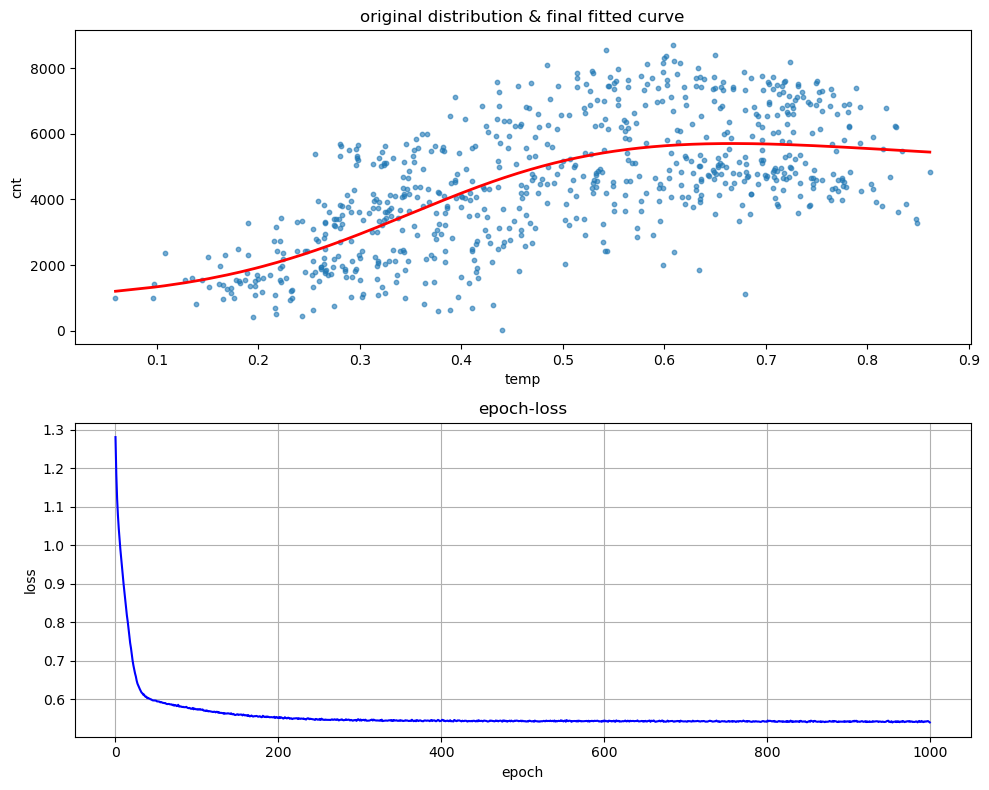

In [71]:
# 创建图表
fig, axs = plt.subplots(2, 1, figsize=(10, 8))

# 显示初始数据的散点图和拟合曲线
axs[0].scatter(X.numpy(), Y.numpy(), s=10, alpha=0.6)# 设置alpha使点变为半透明的
axs[0].set_xlabel('temp')
axs[0].set_ylabel('cnt')
axs[0].set_title('original distribution & final fitted curve')

# 绘制拟合曲线
axs[0].plot(X_sorted.numpy(), y_pred.detach().numpy(), color='r', linewidth=2)

# 绘制epoch-loss图
axs[1].plot(range(len(loss_data)), loss_data, color='b')
axs[1].set_xlabel('epoch')
axs[1].set_ylabel('loss')
axs[1].set_title('epoch-loss')
axs[1].grid(True) #使用网格

plt.tight_layout()
plt.show()

+ 经过上述调整后，得到了一条优美的曲线。经过我的测试，在训练轮数为1000轮时，学习率lr = 0.001最佳。若高于这个值，损失函数的震荡会比较明显；低于这个值，损失函数值会较高。

***
## 思考题
+ 定义一个只含有线性层和激活函数ReLU的模型

In [78]:
class LinearReLUModel(nn.Module):
    def __init__(self, in_features, out_features, bias = True):
        super().__init__()
        self.linear = nn.Linear(in_features, out_features, bias = bias)
        self.relu = nn.ReLU()

    def forward(self,x):
        x = self.linear(x)
        x = self.relu(x)
        return x

In [79]:
# 数据标准化
X_mean, X_std = X.mean(), X.std()
X_normalized = (X - X_mean) / X_std

Y_mean, Y_std = Y.mean(), Y.std()
Y_normalized = (Y - Y_mean) / Y_std

#重载数据集并设置超参数
dataset = TensorDataset(X_normalized,Y_normalized)
train_data = DataLoader(dataset,batch_size=batch_size ,shuffle=True)

In [81]:
#创建网络并初始化
net = LinearReLUModel(1,1)
net.apply(init_params)

#加载数据集并设置超参数
lr = 0.001
epoch_nums = 1000
loss_data = []# 由于存储损失值
optimizer = torch.optim.Adam(net.parameters(), lr=lr)
# 开始训练
for epoch in range(epoch_nums + 1):
    epoch_losses = []  # 存储当前epoch的所有batch损失
    for x, y in train_data:
        optimizer.zero_grad()
        y_hat = net(x)
        loss = criterion(y_hat, y)  # 注意参数顺序：预测值在前，真实值在后
        # loss是一个零维张量
        loss.backward()
        optimizer.step()
        epoch_losses.append(loss.item())  # 存储标量值
    
    # 计算当前epoch的平均损失
    avg_loss = np.mean(epoch_losses)
    loss_data.append(avg_loss)  # 存储每个epoch的平均损失
    
    if epoch % 100 == 0 and epoch != 0:
        print(f'Epoch:{epoch} Loss: {avg_loss:.4f}')

# 打印训练后得到的参数
print("训练后的参数:")
print(net.state_dict())

Epoch:100 Loss: 0.8510
Epoch:200 Loss: 0.8499
Epoch:300 Loss: 0.8485
Epoch:400 Loss: 0.8520
Epoch:500 Loss: 0.8477
Epoch:600 Loss: 0.8497
Epoch:700 Loss: 0.8499
Epoch:800 Loss: 0.8478
Epoch:900 Loss: 0.8474
Epoch:1000 Loss: 0.8531
训练后的参数:
OrderedDict([('linear.weight', tensor([[0.3488]])), ('linear.bias', tensor([0.2105]))])


In [83]:
X_normalized_sorted, indices = torch.sort(X_normalized, dim=0)
# 预测时也要标准化输入，然后反标准化输出
with torch.no_grad():
    net.eval()
    y_pred_normalized = net(X_normalized_sorted)
    y_pred = y_pred_normalized * Y_std + Y_mean  # 反标准化

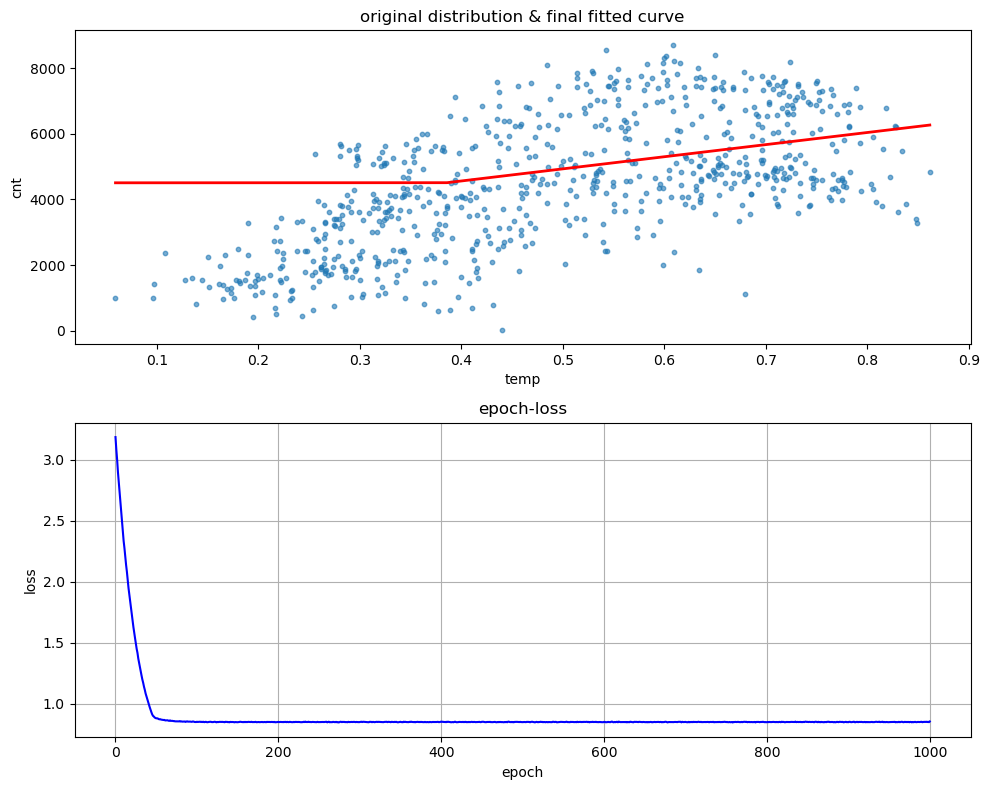

In [84]:
# 创建图表
fig, axs = plt.subplots(2, 1, figsize=(10, 8))

# 显示初始数据的散点图和拟合曲线
axs[0].scatter(X.numpy(), Y.numpy(), s=10, alpha=0.6)# 设置alpha使点变为半透明的
axs[0].set_xlabel('temp')
axs[0].set_ylabel('cnt')
axs[0].set_title('original distribution & final fitted curve')

# 绘制拟合曲线
axs[0].plot(X_sorted.numpy(), y_pred.detach().numpy(), color='r', linewidth=2)

# 绘制epoch-loss图
axs[1].plot(range(len(loss_data)), loss_data, color='b')
axs[1].set_xlabel('epoch')
axs[1].set_ylabel('loss')
axs[1].set_title('epoch-loss')
axs[1].grid(True) #使用网格

plt.tight_layout()
plt.show()

+ **结果分析**：此次训练和任务二采用了一样的参数。可以看到最后的拟合曲线是一个折线，这是因为ReLU函数的特性是将输入为零的数输出为零。解决办法的话可以使用ReLU函数的变种或者在标准化输入后加上偏置。（后续的工作可以是实践改进措施和阅读相关论文《Empirical Evaluation of Rectified Activations in Convolutional Network》，这很重要，可能会是加分项和面试内容）